# **Hand On!**

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2022/11/10<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers



In [4]:
# Print GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [13]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

^C


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 64332    0     0   114k      0  1:57:18 --:--:--  1:57:18  114k
  0  786M    0 2190k    0     0  1427k      0  0:09:24  0:00:01  0:09:23 1427k
  0  786M    0 5908k    0     0  2327k      0  0:05:46  0:00:02  0:05:44 2328k
  1  786M    1 9527k    0     0  2692k      0  0:04:59  0:00:03  0:04:56 2692k
  1  786M    1 13.9M    0     0  3148k      0  0:04:15  0:00:04  0:04:11 3148k
  2  786M    2 18.4M    0     0  3412k      0  0:03:56  0:00:05  0:03:51 3775k
  2  786M    2 22.3M    0     0  3477k      0  0:03:51  0:00:06  0:03:45 4101k
  3  786M    3 26.7M    0     0  3631k      0  0:03:41  0:00:07  0:03:34 4292k
  4  786M    4 31.4M    0     0  3716k      0  0:03:36  0:00:08  0:03:28 4422k
  4  786M    4 35.8M    0     0  3853k      0  0:03

In [14]:

!tar -xf kagglecatsanddogs_5340.zip

"ls" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [16]:
!dir PetImages

 Il volume nell'unit� D non ha etichetta.
 Numero di serie del volume: 3212-F3AF

 Directory di d:\Lovaion\University\2nd Year\Deep Learning\Lab\Convolutional NN\PetImages

28/10/2023  12:28    <DIR>          .
28/10/2023  12:28    <DIR>          ..
10/02/2017  11:01    <DIR>          Cat
10/02/2017  11:12    <DIR>          Dog
               0 File              0 byte
               4 Directory  790.506.999.808 byte disponibili


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [17]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

## Generate a `Dataset`

In [6]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

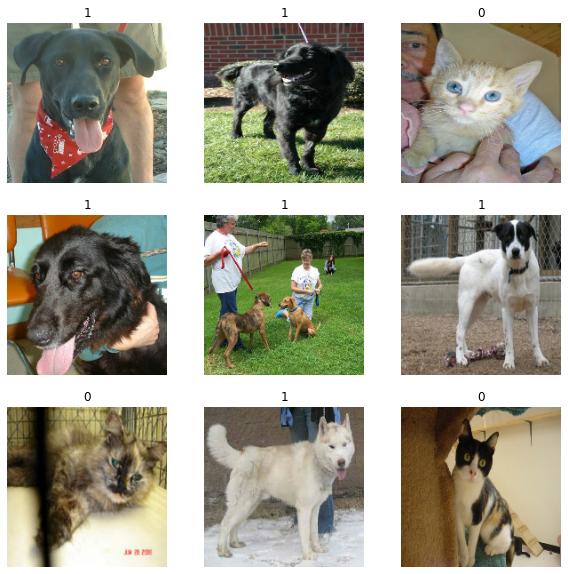

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [7]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)



Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

In [6]:
## Standardizing the data

#Our image are already in a standard size (180x180), as they are being yielded as
#contiguous `float32` batches by our dataset. However, their RGB channel values are in
#the `[0, 255]` range. This is not ideal for a neural network;
#in general you should seek to make your input values small. Here, we will
#standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
#our model.

from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



## Build a model

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

## Train the model

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.